In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/video-data/video_features.pkl
/kaggle/input/video-data/your_data_modified.json
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosoW6n7Diprtc.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosgtTf3vZEwQw.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosnvqY5ybRcng.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videos62IUlW4Z0tM.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosmZMu7chHUeU.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videos5jFtfJNr4Nc.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videos9GO2GANxDGY.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosSVyaKQHvyJ8.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosBzUf5o7DlXY.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videosDlf9LN1QCFg.mp4
/kaggle/input/video-data/data-20231225T155956Z-001/data/videoskE1BpSp5ZVg.mp4
/kaggle/input/video-data/data-20231225T155956Z-00

In [2]:
#video encoder ---- uses inception v3


import os
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

def load_video(video_path, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_videos_from_folder(folder_path, n_videos):
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.mp4')][:n_videos]
    videos = []
    for video_file in tqdm(video_files, desc="Loading Videos"):
        video_path = os.path.join(folder_path, video_file)
        video = load_video(video_path)
        videos.append(video)
    return videos, video_files

def build_encoder_model(input_shape=(None, 224, 224, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

def extract_features(videos, encoder_model, max_frames=4096):
    features = {}
    for i, video in enumerate(tqdm(videos, desc="Extracting Features")):
        video = preprocess_input(video)
        feature = encoder_model.predict(video)
        video_name = video_file_names[i]

        # Ensure a fixed-size feature vector by considering the maximum number of frames
        num_frames = feature.shape[0]
        if num_frames >= max_frames:
            feature = feature[:max_frames, :]
        else:
            # If the number of frames is less than max_frames, zero-pad to max_frames
            pad_frames = max_frames - num_frames
            feature = np.pad(feature, ((0, pad_frames), (0, 0)), mode='constant', constant_values=0)

        features[video_name] = feature
    return features


if __name__ == "__main__":
    folder_path = "/kaggle/input/video-data/data-20231225T155956Z-001/data"
    # try with diff n_videos
    n_videos = 3
   
    videos, video_file_names = load_videos_from_folder(folder_path, n_videos)


    encoder_model = build_encoder_model()


    video_features = extract_features(videos, encoder_model)

    


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Extracting Features:   0%|          | 0/3 [00:00<?, ?it/s]

138/138 [==============================] - 15s 69ms/step


Extracting Features:  33%|███▎      | 1/3 [00:21<00:43, 21.84s/it]

173/173 [==============================] - 11s 65ms/step


Extracting Features:  67%|██████▋   | 2/3 [00:41<00:20, 20.74s/it]

150/150 [==============================] - 10s 68ms/step


Extracting Features: 100%|██████████| 3/3 [00:59<00:00, 19.89s/it]


In [4]:
import pickle
with open( "video_features.pkl", 'wb') as file:
    pickle.dump(video_features, file)
#np.save("video_features.npy", video_features_dict)

In [5]:
# start---------
import pickle
with open( "/kaggle/input/video-data/video_features.pkl", 'rb') as file:
    video_features = pickle.load(file)
#video_features = np.load("video_features.npy")

In [6]:
vid_feature_dict = {key.replace('videos', '').replace('.mp4', ''): value for key, value in video_features.items()}

In [7]:
import pandas as pd
question_df = pd.read_json("/kaggle/input/video-data/your_data_modified.json")


filter_values = list(vid_feature_dict.keys())
question_df = question_df[question_df['video_id'].isin(filter_values)]
question_df.head()

,video_id,start_time,end_time,question,answer
28,nvqY5ybRcng,4.87619,82.358857,What will she teach?,greeting
29,nvqY5ybRcng,4.87619,82.358857,What time of day is it?,morning
30,nvqY5ybRcng,4.87619,82.358857,How is the greeting called?,1 minute greeting
31,nvqY5ybRcng,4.87619,82.358857,What do they do after greeting?,go back
32,nvqY5ybRcng,4.87619,82.358857,What color is the teacher's sweater?,pink


In [8]:
import numpy as np
train_q = np.array(question_df['question'])
train_a = np.array(question_df['answer'])
train_n = np.array(['eos', 'bos'])
txt = np.concatenate((train_a, train_q, train_n), axis=None)

from tensorflow.keras.preprocessing.text import Tokenizer 
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(txt)

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def preprocess_text_data(tokenizer, texts,ans,  max_sequence_length, max_ans_length):
   
    
    
    sequences = tokenizer.texts_to_sequences(texts)
    print(len(tokenizer.word_index))
    ans_sequences = tokenizer.texts_to_sequences(ans)
    
    print(len(tokenizer.word_index))
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    ans_padded_sequences = pad_sequences(ans_sequences, maxlen=max_ans_length)
    return padded_sequences, ans_padded_sequences,  tokenizer.word_index


max_sequence_length = question_df.question.str.len().max()

# try with different lengths
max_ans_length = 2
max_sequence_length = 20
padded_questions,ans_padded_sequences, word_index = preprocess_text_data(tokenizer, question_df.question,question_df.answer,   max_sequence_length, max_ans_length)


69
69


In [10]:
tokenizer

In [11]:
ans_padded_sequences[6]

array([ 0, 20], dtype=int32)

In [12]:

vocabulary_size = len(tokenizer.word_index) + 1

In [13]:
word_to_token = tokenizer.word_index
token_to_word = tokenizer.index_word
word_to_token

{'the': 1,
 'what': 2,
 'is': 3,
 'how': 4,
 'do': 5,
 'greeting': 6,
 'of': 7,
 'they': 8,
 'color': 9,
 '1': 10,
 'many': 11,
 'minute': 12,
 'teacher': 13,
 'time': 14,
 'kids': 15,
 'top': 16,
 'morning': 17,
 'go': 18,
 'back': 19,
 'pink': 20,
 'timer': 21,
 'a': 22,
 'will': 23,
 "teacher's": 24,
 'have': 25,
 'greet': 26,
 'are': 27,
 'there': 28,
 'in': 29,
 'blue': 30,
 'good': 31,
 'green': 32,
 '2': 33,
 'yellow': 34,
 '15': 35,
 '4': 36,
 'by': 37,
 'using': 38,
 'she': 39,
 'teach': 40,
 'day': 41,
 'it': 42,
 'called': 43,
 'after': 44,
 'sweater': 45,
 'heard': 46,
 'before': 47,
 "woman's": 48,
 "michael's": 49,
 'job': 50,
 'woman': 51,
 'each': 52,
 'other': 53,
 'much': 54,
 'to': 55,
 'use': 56,
 'when': 57,
 'hear': 58,
 'beep': 59,
 'carpet': 60,
 'adults': 61,
 'video': 62,
 "nichole's": 63,
 'classroom': 64,
 'answered': 65,
 'question': 66,
 'measure': 67,
 'eos': 68,
 'bos': 69}

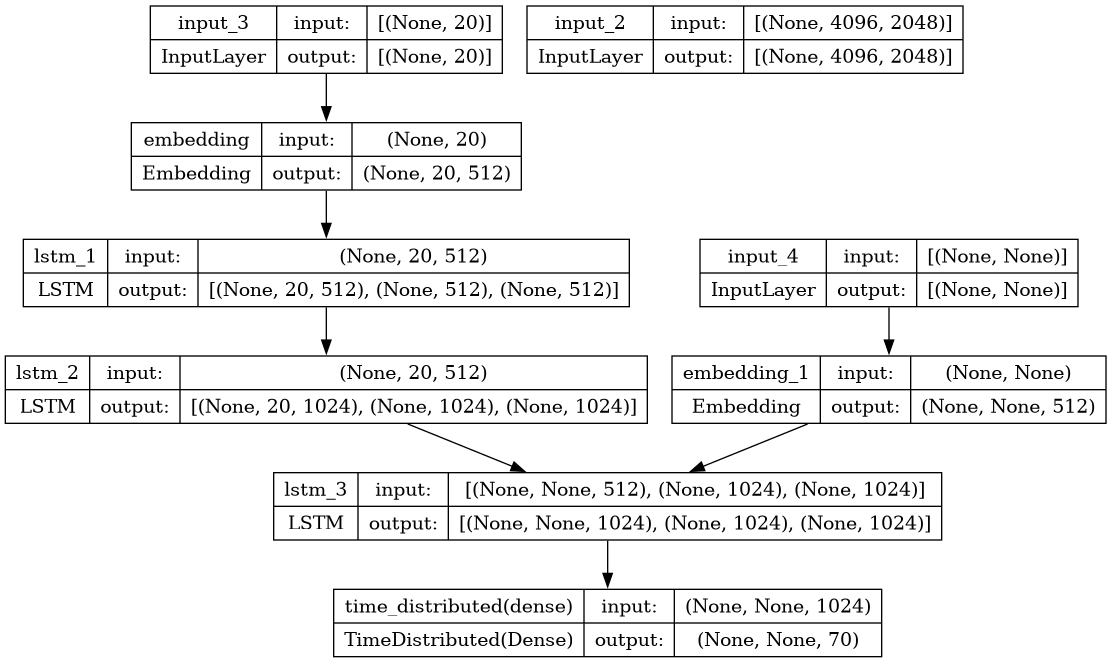

In [14]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Attention, Input, Concatenate, TimeDistributed, Dropout
from tensorflow.keras.utils import plot_model
embedding_dim = 512
tf.config.run_functions_eagerly(True)
# Video Encoder 
video_encoder_inputs = Input(shape=(4096,2048))

#LSTM 1 
video_encoder_lstm1 = LSTM(units=1024, return_sequences=True,return_state=True) 
video_encoder_output1, state_h1, state_c1 = video_encoder_lstm1(video_encoder_inputs)


# Question encoder

question_inputs = Input(shape=(max_sequence_length,)) 
q_emb =  Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length)(question_inputs) 
#LSTM 1 
q_lstm1 = LSTM(embedding_dim,return_sequences=True,return_state=True) 
q_output1, q_state_h1, q_state_c1 = q_lstm1(q_emb) 

#LSTM 2 
q_lstm2 = LSTM(1024,return_sequences=True,return_state=True) 
q_output2, state_h, state_c = q_lstm2(q_output1)
#q_output3 = Dense(1024, activation='tanh')(q_output2)



attn_out = Attention()([q_output2 , video_encoder_output1]) 

#attn_out = Concatenate(axis=-1, name='concat_layer')([video_encoder_output1, attn_out])

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer =  Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_ans_length)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(1024, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Dense layer
decoder_dense = TimeDistributed(Dense(vocabulary_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model
model = Model([video_encoder_inputs, question_inputs, decoder_inputs], decoder_outputs) 
plot_model(model, to_file='train_model.png', show_shapes=True)

In [15]:
print(state_h.shape, state_c.shape)

(None, 1024) (None, 1024)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [17]:
import numpy as np
filtered_values = np.array([vid_feature_dict[key] for key in question_df['video_id']])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split( padded_questions,ans_padded_sequences, filtered_values, test_size=0.2, random_state=42)

In [19]:
#Train on entire data (for testing the model)
history = model.fit([ filtered_values,padded_questions, ans_padded_sequences[:,:-1]], ans_padded_sequences.reshape(ans_padded_sequences.shape[0], ans_padded_sequences.shape[1])[:,1:], 
                    epochs=40, 
                    callbacks=[es],
                    batch_size=1,
                   )


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/40
19/19 [==============================] - 2s 83ms/step - loss: 4.4424 - accuracy: 0.0526
Epoch 2/40
19/19 [==============================] - 2s 87ms/step - loss: 3.9701 - accuracy: 0.0000e+00
Epoch 3/40
19/19 [==============================] - 2s 81ms/step - loss: 3.1485 - accuracy: 0.1579
Epoch 4/40
19/19 [==============================] - 1s 78ms/step - loss: 3.0615 - accuracy: 0.1579
Epoch 5/40
19/19 [==============================] - 2s 85ms/step - loss: 2.5110 - accuracy: 0.1053
Epoch 6/40
19/19 [==============================] - 2s 81ms/step - loss: 3.1628 - accuracy: 0.1579
Epoch 7/40
19/19 [==============================] - 2s 80ms/step - loss: 1.8444 - accuracy: 0.3684
Epoch 8/40
19/19 [==============================] - 2s 82ms/step - loss: 1.5649 - accuracy: 0.5263
Epoch 9/40
19/19 [==============================] - 2s 78ms/step - loss: 1.5949 - accuracy: 0.4737
Epoch 10/40
19/19 [==============================] - 1s 79ms/step - loss: 1.4764 - accuracy: 0.4737
Epoch

In [ ]:
# do not run
history = model.fit([ c_train,X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1])[:,1:], 
                    epochs=20, 
                    callbacks=[es],
                    batch_size=1,
                   )


In [ ]:
# to do ---- not yet working

In [20]:
####model1 inference  # reference == https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

latent_dim=512
# encoder inference

#print(encoder_outputs.shape)

video_model = Model(inputs=video_encoder_inputs,outputs=[video_encoder_output1, state_h1, state_c1])

question_model = Model(inputs=question_inputs,outputs=[q_output2, state_h, state_c]) #encoder

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(1024,))
decoder_state_input_c = Input(shape=(1024,))

decoder_hidden_state_input = Input(shape=(None, 1024))
decoder_context_state_input = Input(shape=(None, 1024))

attn_out = Attention()([q_output2 , video_encoder_output1]) 

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_context_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [21]:
def decode_sequence2(input_seq, conext_seq):
    max_a_len = 10
    # Encode the input as state vectors.
    e_out, e_h, e_c = question_model.predict([input_seq])
    print("encoder 1 working")
    c_out, c_h, c_c = video_model.predict([conext_seq])
    print("encoder 2 working")
    #context_output, context_state_h, context_state_c = context_model.predict(context)
    #context_vector, attention_weights = att(e_h, context_output)
   
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'bos' word as the first word of the target sequence
    target_seq[0, 0] = word_to_token['bos']
    stop_condition = False
    decoded_sentence = ''
    print("going to while loop")
    i = 0
    while not stop_condition:
        i+=1
        if(i>5):
            stop_condition = True
        #print("in while loop")
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out,c_out, e_h, e_c])
        #print("decoder working")
        # prediction
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print(sampled_token_index)
        if sampled_token_index == 0:
            continue
            #change it to break
            
        else:
            sampled_token = token_to_word[sampled_token_index]
        if(sampled_token!='eos'):
              decoded_sentence += ' '+sampled_token
        # stop prediction condition
        if (sampled_token == 'eos' or len(decoded_sentence.split()) >= (max_a_len)):
                  stop_condition = True
        # Update the target sequence 
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    print(decoded_sentence)
    return decoded_sentence

In [22]:
print('predicted')
# try diff example values
example = 6
print(decode_sequence2(X_train[example].reshape(1, max_sequence_length),c_train[example].reshape(1, 4096, 2048)))
#print(decode_sequence2(X_train,c_train))

predicted
1/1 [==============================] - 0s 34ms/step
encoder 1 working
1/1 [==============================] - 0s 379ms/step
encoder 2 working
going to while loop
1/1 [==============================] - 0s 44ms/step
6
1/1 [==============================] - 0s 42ms/step
6
1/1 [==============================] - 0s 34ms/step
6
1/1 [==============================] - 0s 43ms/step
6
1/1 [==============================] - 0s 46ms/step
6
1/1 [==============================] - 0s 46ms/step
6
 greeting greeting greeting greeting greeting greeting
 greeting greeting greeting greeting greeting greeting


In [23]:
def decode_accuracy2(input_seq, conext_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = question_model.predict([input_seq])
    c_out, c_h, c_c = video_model.predict([conext_seq])
    #context_output, context_state_h, context_state_c = context_model.predict(context)
    #context_vector, attention_weights = att(e_h, context_output)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Chose the 'bos' word as the first word of the target sequence
    target_seq[0, 0] = word_to_token['bos']
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out,c_out, e_h, e_c])
        # prediction
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index == 0:
            break
        else:
            sampled_token = token_to_word[sampled_token_index]
        if(sampled_token!='eos'):
              decoded_sentence.append(sampled_token_index)
        # stop prediction condition
        if (sampled_token == 'eos' or len(decoded_sentence) >= (max_a_len)):
                  stop_condition = True
        # Update the target sequence 
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c
    return decoded_sentence

In [24]:
# calculation of precision recall
#X_train, X_test, y_train, y_test, c_train, c_test
#Precision = #common idxs / #predicted idxs
#Recall = #common idxs / #ground truth idxs
rec = 0
prec = 0
from tqdm import tqdm
for i in tqdm(range(len(X_test[1:1000]))):

    x=X_test[i]
    y=y_test[i]
    c=c_test[i]
    pred = decode_accuracy2(x.reshape(1, max_sequence_length),c.reshape(1, 4096, 2048))
    lcs_score = lcs(y, pred, len(y), len(pred))
    if(len(pred) != 0):
        prec += (lcs_score/len(pred))
    else:
        prec += (lcs_score/1)
    rec += (lcs_score/len(y))
print('precision : ', (prec/len(X_test)))
print('recall : ', (rec/len(X_test)))
prec = prec/len(X_test)
rec = rec/len(X_test)
f_meaure =  (2*prec*rec)/(prec+rec)
print('f_meaure :',f_meaure)

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'max_a_len' is not defined

In [25]:
X_test[0].reshape(1, max_sequence_length).shape, X_test[0].shape

((1, 20), (20,))

In [26]:
X_train, X_test, y_train, y_test, c_train, c_test

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  1,
         50,  7,  1, 51],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 11, 15, 27,
         28, 29,  1, 64],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  5,
          8,  5, 44,  6],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
          9,  3,  1, 60],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  1,
          9,  7, 63, 16],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 11, 15,
         65,  1, 24, 66],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,
          3,  1,  6, 43],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  5,
          8, 26, 52, 53],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  5,
          1, 13, 67, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  9,
          3,  1, 24, 45],
        [ 

In [27]:
#model 1 
from keras import backend as K 
K.clear_session() 
latent_dim = 300 
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding, Concatenate, TimeDistributed,Attention
from tensorflow.keras.models import Model,load_model, model_from_json
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pkl
import numpy as np

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
K.clear_session() 
latent_dim = 512
# Encoder 
encoder_inputs = Input(shape=(max_sequence_length,)) 
enc_emb = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length)(encoder_inputs)
#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output, state_h, state_c = encoder_lstm2(encoder_output1)
'''

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
'''

#context lstm
 
context_inputs = Input(shape=(max_sequence_length,)) 
contxt_emb = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length)(context_inputs) 
#LSTM 1 
context_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
context_output1, context_state_h1, context_state_c1 = context_lstm1(contxt_emb) 


#LSTM 2 
context_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
context_output, context_state_h, context_state_c = context_lstm2(context_output1)

'''
#LSTM 3 
context_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True) 
context_output, context_state_h, context_state_c = context_lstm3(context_output2)
'''


# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer =  Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length)
dec_emb = dec_emb_layer(decoder_inputs)
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_out = Attention()([decoder_outputs , context_output]) 
#attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])


# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#Dense layer
decoder_dense = TimeDistributed(Dense(voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, context_inputs, decoder_inputs], decoder_outputs) 
plot_model(model, to_file='train_model.png', show_shapes=True)

NameError: name 'voc_size' is not defined

In [28]:
v_encoder.summary()

NameError: name 'v_encoder' is not defined

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Concatenate

from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
import h5py
embedding_dim = 256
def Word2VecModel( vocabulary_size, embedding_dim, max_sequence_length, dropout_rate=0.1):
    print("Creating text model...")
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))
    #model.add(Embedding(num_words, embedding_dim, 
    #    weights=[embedding_matrix], input_length=seq_length, trainable=False))
    model.add(LSTM(units=512, return_sequences=True, input_shape=(max_sequence_length, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='tanh'))
    return model

def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    model.add(Dense(1024, input_dim=4096, activation='tanh'))
    return model

def vqa_model(vocabulary_size, embedding_dim, max_sequence_length, num_classes, dropout_rate=0.1):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(vocabulary_size, embedding_dim, max_sequence_length, dropout_rate=0.1)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Concatenate()([vgg_model, lstm_model]))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(num_classes, activation='softmax'))
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
        metrics=['accuracy'])
    return fc_model

In [30]:
model = vqa_model(vocabulary_size, embedding_dim, max_sequence_length, 0.1)

Creating image model...
Creating text model...
Merging final model...


TypeError: object of type 'NoneType' has no len()